<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow_addons
!pip install nlpaug
!pip install tqdm

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import collections

import nlpaug.augmenter.word as naw

import pickle
from tqdm import tqdm

from nlpaug.util import Action

import tensorflow_addons as tfa
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Flatten, RepeatVector, Permute, Activation, Dropout, Bidirectional, Multiply, Lambda

## Loading data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_dataset.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv')
df_val = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv')

### Data Augementation

As seen above, our dataset is imbalanced. To achieve good performance from the models, we need to balance the data. Data augmentation techniques can be used to generate additional, synthetic data using the existing data.
We have used a python library, NLPAug to achieve this.

NLPAug offers three types of augmentation:
1. Character level augmentation
2. Word level augmentation 
3. Sentence level augmentation
Each of these types can be performed with actions like random deletion, random insertion, shuffling, synonym replacement, etc.

Here, we have used synonym replacement action for Word level augmentation, which randomly picks a word from a sentence and replaces it with a synonym of the word( use word embeddings to find most similar group of words to replace original word).



In [ ]:
def augment_text(df,samples=3000,pr=0.2):
  aug = naw.WordEmbsAug(
  model_type='glove', model_path='/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt',
  action="substitute")

  aug.aug_p=pr
  new_text=[]
  
  ##selecting the minority class samples
  df_n=df[df.Label==0].reset_index(drop=True)

  ## data augmentation loop
  for i in tqdm(np.random.randint(0,len(df_n),samples)):
      
          text = df_n.iloc[i]['Sentences']
          augmented_text = aug.augment(text)
          new_text.append(augmented_text)
  
  
  ## dataframe
  new=pd.DataFrame({'Sentences':new_text,'Label':0})
  df=shuffle(df.append(new).reset_index(drop=True))
  return df

In [ ]:
## Uncomment this cell to run Data augmentation on the train dataset

# train = augment_text(df_train)
# train.drop('Unnamed: 0', axis=1, inplace=True)
# train.reset_index(drop=True,inplace=True)

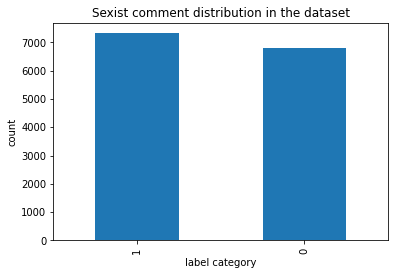

In [ ]:
train['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset after augmentation')
plt.show()

From the above plot, we can see that the class distribution is balanced after data augmentation.

In [ ]:
## Uncomment this cell to save the augmented train data

# train.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [ ]:
X_train = df_train[['Sentences']]
y_train = df_train['Label']

X_val = df_val[['Sentences']]
y_val = df_val['Label']

X_test = df_test[['Sentences']]
y_test = df_test['Label']

In [ ]:
X_train.tail()

,Sentences
14106,having to state your marital status times a d...
14107,my mother commenting on my outfit dont cry to ...
14108,a good man acknowledges a woman than another p...
14109,agree to an extent
14110,joker doesnt even work with a woman besides wa...


In [ ]:
X_train.shape, X_val.shape, X_test.shape

((14111, 1), (273, 1), (228, 1))

In [ ]:
#!unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

### Loading the Gender neutral GLoVe embedding

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
embedding_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [ ]:
word_to_vec_map['and'].shape

(300,)

In [ ]:
vocab = list(words_to_index.keys())

In [ ]:
len(vocab)

142527

### Getting word embeddigs for the input data - X_train and X_test

In [ ]:
def get_tokens_embedding_list(data, vocab, word_to_vec_map):
  embedding_list = []
  for sent_seq in data:
    tensor_list=[]
    for word in sent_seq[0].split():
      if word in vocab:
        tensor_list.append(word_to_vec_map[word])
        #print(len(tensor_list))
    embedding_list.append(tensor_list)
  return embedding_list

In [ ]:
## Note: This takes a lot of time to create embeddings list as the dataset is huge. Please load the embedding list from the cell below.

# X_train_embedding = get_tokens_embedding_list(X_train.values, vocab, word_to_vec_map)
# with open('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_embedding_list_1', 'wb') as f:
#   pickle.dump(X_train_embedding, f)

In [ ]:
with open('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_embedding_list_1', 'rb') as f:
  X_train_embedding = pickle.load(f)

In [ ]:
X_val_embedding = get_tokens_embedding_list(X_val.values, vocab, word_to_vec_map)

In [ ]:
X_test_embedding = get_tokens_embedding_list(X_test.values, vocab, word_to_vec_map)

In [ ]:
def create_dataset(data_in, target_in):
   
    #Get the length of each sentence
    N = [len(data_in[i]) for i, _ in enumerate(data_in)]
    embedding_size = 300
    tensor_N = tf.constant(N, tf.int32)
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    print(ragged_input.shape)

    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, target_in))
    del ragged_input

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    
    # Transform_pad function is defined above; you can change the num_parallel_calls
    dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, embedding_size]), y), num_parallel_calls=3)   
                          
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_dataset = create_dataset(X_train_embedding, y_train)
val_dataset = create_dataset(X_val_embedding, y_val)

(14111, None, None)
(273, None, None)


In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, None, 300), (None,)), types: (tf.float32, tf.int64)>

### Bidirectional LSTM Model


The model employs a Bidirectional LSTM deep learning architecture. After extracting the embeddings for the input sentences from Gender neutral GLoVe, inputs are propagated through two bidirectional LSTM layers.

This model should be able to read the sentences both forwards and backwards to better learn their nuanced meanings.

In [ ]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)
bid_lstm_2 = Bidirectional(LSTM(128, return_sequences=False))(dropout_1)
dropout_2 = Dropout(0.5)(bid_lstm_2)
dense = Dense(1, activation='sigmoid')(dropout_2)

lstm_model = Model(inputs=input_layer, outputs=dense)

In [ ]:
lstm_model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, None, 256)         439296    
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 833,793
Trainable params: 833,793
Non-trainable params: 0
____________________________________________________

In [ ]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='bce', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1, callbacks=[callback])

Epoch 1/10
221/221 [==============================] - 29s 111ms/step - loss: 0.5922 - accuracy: 0.6899 - val_loss: 0.6578 - val_accuracy: 0.6117
Epoch 2/10
221/221 [==============================] - 23s 105ms/step - loss: 0.5475 - accuracy: 0.7253 - val_loss: 0.6156 - val_accuracy: 0.6703
Epoch 3/10
221/221 [==============================] - 23s 103ms/step - loss: 0.5179 - accuracy: 0.7393 - val_loss: 0.5949 - val_accuracy: 0.6960
Epoch 4/10
221/221 [==============================] - 23s 104ms/step - loss: 0.4903 - accuracy: 0.7558 - val_loss: 0.5473 - val_accuracy: 0.7582
Epoch 5/10
221/221 [==============================] - 23s 103ms/step - loss: 0.4562 - accuracy: 0.7790 - val_loss: 0.5484 - val_accuracy: 0.7436
Epoch 6/10
221/221 [==============================] - 23s 104ms/step - loss: 0.4274 - accuracy: 0.7989 - val_loss: 0.5634 - val_accuracy: 0.7363


Train accuracy is: 79.89%
Validation accuracy is: 73.63%

In [ ]:
def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    for i, metric in enumerate(['loss', 'accuracy']): 
        ax[i].plot(history.history[metric], label='Train')
        ax[i].plot(history.history['val_'+metric], label='Validation')
        if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel(metric)
    plt.suptitle(f'{name} Training', y=1.05)
    plt.legend()
    plt.tight_layout()

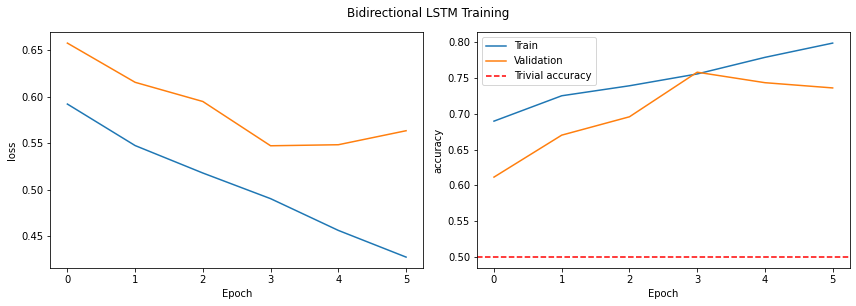

In [ ]:
plot_history(history, 'Bidirectional LSTM')

We can see that the validation loss is increasing and accuracy decreasing after 3 epochs. So, the training stopped after 5 epochs(EarlyStopping with patience 2) to avoid overfitting.

In [ ]:
## Uncomment this cell to save the trained LSTM model

# lstm_model.save('/content/drive/MyDrive/AI-3 Project/Models/lstm_model_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_model_1/assets


In [ ]:
lstm_model = load_model('/content/drive/MyDrive/AI-3 Project/Models/lstm_model_1')

In [ ]:
# Converting the test set into test dataset
ragged_input_test  = tf.ragged.constant(X_test_embedding, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((ragged_input_test, y_test.values))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(1)
test_dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, 300]),y), num_parallel_calls=3)


In [ ]:
loss, acc = lstm_model.evaluate(test_dataset)

228/228 [==============================] - 2s 5ms/step - loss: 0.5570 - accuracy: 0.7412


In [47]:
print("Test accuracy for Bi-LSTM is: ", acc)

Test accuracy for Bi-LSTM is:  74.12


Bidirectional LSTM model is able to perform better than the baseline model with the test accuracy of 74.12%. As mentioned above, this model is able to capture the meaning of the sentences better.